In [ ]:
!pip install qiskit
!pip install qiskit_optimization
!pip install qiskit_algorithms
!pip install qiskit.quantum_info
!pip install qiskit_machine_learning

ERROR: Could not find a version that satisfies the requirement qiskit.quantum_info (from versions: none)
ERROR: No matching distribution found for qiskit.quantum_info


In [ ]:
import numpy as np

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim

# Qiskit imports
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, Parameter

# Qiskit algorithms imports
from qiskit_algorithms.utils import algorithm_globals

# Qiskit ML imports
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import networkx as nx

""" Note: the code is not optimized for GPU
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [ ]:
def graph_encoding_circuit(edges, num_qubits, reps, params, insert_barriers=True) -> QuantumCircuit:
    """
    Defines the graph encoding quantum circuit.

    Parameters:
    - edges: List of tuples representing edges in the graph.
    - num_qubits: Number of qubits in the quantum circuit.
    - reps: Number of layers (repetitions) in the circuit.
    - params: Symbolic parameters for the circuit.
    - insert_barriers: True if barriers are to be inserted for better visualization (optional).

    Returns:
    QuantumCircuit: The constructed quantum circuit.
    """
    # Create a quantum circuit
    circuit = QuantumCircuit(num_qubits)

    # Apply Hadamard gates to all qubits
    circuit.h(range(num_qubits))

    for rep in range(reps):
        edge_w = params[rep][-1]

        # Edge encoding
        for edge_i, edge in enumerate(edges):
            circuit.cx(edge[0], edge[1])
            circuit.rz(edge_w[edge_i], edge[1])
            circuit.cx(edge[0], edge[1])

        # Insert barrier for better visualization
        if insert_barriers:
            circuit.barrier()

        # Vertex encoding
        for q in range(num_qubits):
            circuit.rx(params[rep][q], q)

    return circuit

In [ ]:
def get_graph_mat(n=10, size=1):
    """Generate n nodes uniformly at random on a square and build a fully connected graph.

    Args:
        n (int): Number of nodes.
        size (float): Size of the square.

    Returns:
        tuple: Tuple containing coordinates matrix (N, 2) and pairwise Euclidean distances matrix (N, N).
    """
    coords = size * np.random.uniform(size=(n, 2))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat

def plot_graph(coords, mat):
    """Utility function to plot the fully connected graph.

    Args:
        coords (np.ndarray): Coordinates matrix.
        mat (np.ndarray): Pairwise Euclidean distances matrix.
    """
    n = len(coords)

    plt.scatter(coords[:, 0], coords[:, 1], s=[50 for _ in range(n)])
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([coords[i, 0], coords[j, 0]], [coords[i, 1], coords[j, 1]], 'b', alpha=0.7)
                distance = mat[i, j]
                mid_x = (coords[i, 0] + coords[j, 0]) / 2
                mid_y = (coords[i, 1] + coords[j, 1]) / 2
                plt.text(mid_x, mid_y, f'{distance:.2f}', color='red', fontsize=8, ha='center', va='center')

def generate_networkx_graph(coords, mat):
    """Generate a NetworkX graph using coordinates and distances matrices.

    Args:
        coords (np.ndarray): Coordinates matrix.
        mat (np.ndarray): Pairwise Euclidean distances matrix.

    Returns:
        nx.Graph: NetworkX graph.
    """
    n = len(coords)
    G = nx.Graph()

    for i in range(n):
        G.add_node(i, pos=(coords[i, 0], coords[i, 1]))

    for i in range(n):
        for j in range(i + 1, n):
            G.add_edge(i, j, weight=mat[i, j])

    return G

In [ ]:
class EquivariantLayer(nn.Module):
    def __init__(
            self,
            num_input_params : int,
            n_vars : int,
            n_edges : int,
            circuit_depth : int,
            params : list):
        """
        Initialize classical equivariant layer.
        :param num_input_params: Number of input parameters.
        :param n_vars: Number of variables.
        :param n_edges: Number of edges.
        :param circuit_depth: Depth of the circuit (repetitions).
        :param params: List of parameters.
        """
        super(EquivariantLayer, self).__init__()

        # Define weights for the Layer
        self.num_input_params = num_input_params * circuit_depth
        self.num_params = 2 * circuit_depth
        self.circuit_depth = circuit_depth

        param_init = torch.ones(1, self.num_params, dtype=torch.float32)
        self.params = torch.nn.Parameter(param_init)

        self.param_repeats = []
        for layer in range(self.circuit_depth):
            self.param_repeats.append(n_vars)
            self.param_repeats.append(n_edges)

        alphabetical_params = sorted(params)
        self.indices = [params.index(a) for a in alphabetical_params]

    def forward(self, inputs):
        """
        Forward execution of the layer.
        :param inputs: Input data.
        :return: Returns the expectation values.
        """
        repeated_params = self.params.repeat_interleave(torch.tensor(self.param_repeats))

        repeat_inputs = inputs.repeat(self.circuit_depth, 1)

        repeated_params = repeated_params.reshape(repeat_inputs.shape)
        data_values = repeat_inputs * repeated_params
        data_values = data_values.view(1, -1)
        output = data_values[:, self.indices]

        return output

In [ ]:
class QModel(nn.Module):
    def __init__(self, n_input_params : int, n_vars : int, num_edges_in_graph : int, n_layers : int,
                 flattened_data_symbols : list, circuit : QuantumCircuit):
        """
        The neural network that will parameterize the function Q.

        :param n_input_params: Number of input parameters.
        :param n_vars: Number of variables in the Equivariant Layer.
        :param num_edges_in_graph: Number of edges in the graph.
        :param n_layers: Number of repetitions/layers.
        :param flattened_data_symbols: Flattened data symbols for the Equivariant Layer.
        :param circuit: The Equivariant Quantum Circuit.
        """
        super(QModel, self).__init__()
        self.n_input_params = n_input_params
        self.n_vars = n_vars
        self.num_edges_in_graph = num_edges_in_graph
        self.n_layers = n_layers
        self.flattened_data_symbols = flattened_data_symbols

        # Classical encoding layer.
        self.encoding_layer = EquivariantLayer(num_input_params=self.n_input_params, n_vars=self.n_vars,
                                               n_edges=self.num_edges_in_graph, circuit_depth=self.n_layers,
                                               params=self.flattened_data_symbols)

        # The Equivariant Quantum Circuit for Torch Connector.
        self.circuit = circuit

    def forward(self, input_data, observables) -> torch.Tensor:
        """
        Forward execution of the neural net.

        :param input_data: Input data.
        :return: Expectation values for all available nodes.
        """
        encoding_output = self.encoding_layer(input_data)
        qnn = TorchConnector(
            EstimatorQNN(
                circuit=self.circuit,
                input_params=self.circuit.parameters,
                observables=observables
            )
        )
        expectation_values = qnn(encoding_output)

        return expectation_values

In [ ]:
class QFunction():
    def __init__(self, model, optimizer, lr_scheduler):
        """
        Initializes the QFunction.

        Parameters:
        - model: The QNet model used for Q-value estimation.
        - optimizer: The optimizer used for updating the model's parameters.
        - lr_scheduler: Learning rate scheduler for adjusting the learning rate during training.
        """
        self.model = model
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = nn.MSELoss()

    def predict(self, state_tsr, observables):
        """
        Predicts Q-values for a given state and observables.

        Parameters:
        - state_tsr: Tensor representing the current state.
        - observables: Additional observables relevant to the Q-value estimation.

        Returns:
        Tensor: Estimated Q-values for each action in the current state.
        """
        # batch of 1 - only called at inference time
        with torch.no_grad():
            estimated_rewards = self.model(state_tsr, observables)
        return estimated_rewards

    def get_best_action(self, state_tsr, observables):
        """
        Computes the best (greedy) action to take from a given state.

        Parameters:
        - state_tsr: Tensor representing the current state.
        - observables: Additional observables relevant to the Q-value estimation.

        Returns:
        Tuple: Contains the ID of the next node and the corresponding estimated Q-Value.
        """
        estimated_q_values = self.predict(state_tsr, observables=observables)
        return torch.argmax(estimated_q_values), torch.max(estimated_q_values)

    def batch_update(self, states_tsrs, observables_batch, actions, targets):
        """
        Takes a gradient step using the loss computed on a batch of (states, Ws, actions, targets).

        Parameters:
        - states_tsrs: List of (single) state tensors.
        - observables_batch: List of observables corresponding to the batch of states.
        - actions: List of actions taken.
        - targets: List of targets (resulting estimated rewards after taking the actions).

        Returns:
        float: The value of the loss incurred during the batch update.
        """
        self.optimizer.zero_grad()

        # the rewards estimated by Q for the given actions
        estimated_q_vals = []
        for i in range(len(states_tsrs)):
            estimated_q_vals.append(self.model(states_tsrs[i], observables_batch[i]))
        estimated_q_vals = torch.stack(estimated_q_vals).squeeze(dim=1)  # [range(len(actions)), actions]
        estimated_q_vals, _ = torch.max(estimated_q_vals, dim=1, keepdim=True)
        estimated_q_vals = estimated_q_vals.squeeze(dim=1)

        loss = self.loss_fn(estimated_q_vals, torch.tensor(targets, dtype=torch.float32, device=device))
        loss_val = loss.item()

        loss.backward()
        self.optimizer.step()
        self.lr_scheduler.step()

        return loss_val

In [ ]:
from collections import namedtuple
import random

# Named tuple to represent an experience in the replay memory
Experience = namedtuple('Experience', ('state', 'state_tsr', 'action', 'reward', 'next_state', 'next_state_tsr'))

class Memory(object):
    def __init__(self, capacity):
        """
        Initializes a replay memory.

        Parameters:
        - capacity: Maximum capacity of the replay memory.
        """
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0

    def remember(self, experience):
        """
        Records an experience in the replay memory.

        Parameters:
        - experience: An instance of the Experience namedtuple containing state, state tensor,
                      action, reward, next state, and next state tensor.
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        self.nr_inserts += 1

    def sample_batch(self, batch_size):
        """
        Samples a batch of experiences from the replay memory.

        Parameters:
        - batch_size: The number of experiences to sample in a batch.

        Returns:
        List: A list containing randomly sampled experiences from the replay memory.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """
        Returns the current number of experiences stored in the replay memory.

        Returns:
        int: The number of experiences stored in the replay memory.
        """
        return min(self.nr_inserts, self.capacity)

In [ ]:
def total_distance(tour, weight_mat):
    """
    Computes the total distance of a given tour in a TSP.

    Parameters:
    - tour: List of edges representing the tour.
    - weight_mat: Weight (distance) matrix for the graph.

    Returns:
    float: Total distance of the tour.
    """
    total_dist = 0

    for edge in tour:
        # Extract the node indices from the edge
        node1, node2 = edge

        # Retrieve the weight (distance) from the adjacency matrix
        dist = weight_mat[node1][node2]

        # Add the distance to the total
        total_dist += dist

    # Check if the tour is a cycle (going through all vertices)
    if len(set(node for edge in tour for node in edge)) == len(weight_mat):
        # Add the distance from the last node to the first one
        last_node, first_node = tour[-1][1], tour[0][0]
        total_dist += weight_mat[last_node][first_node]

    return total_dist

def graph_to_list(nodes: list, edge_weights: dict, available_nodes: list[int]) -> list[float]:
    """
    Converts a graph representation into a list of values.

    Parameters:
    - nodes: List of graph nodes.
    - edge_weights: Dictionary of edge weights.
    - available_nodes: List of available nodes.
    - partial_tour: Partial tour of the TSP.

    Returns:
    list[float]: List of values representing the graph.
    """
    vals = []
    for node in nodes:
        n = int(node in available_nodes)
        vals.append(n * np.pi)

    for w in edge_weights:
        vals.append(np.arctan(w))

    return vals

def get_observables(partial_tour, available_nodes, weight_mat, nodes):
    """
    Generates observables for the Quantum Circuit based on the partial tour.

    Parameters:
    - partial_tour: Partial tour of the TSP.
    - available_nodes: List of available nodes.
    - weight_mat: Weight (distance) matrix for the graph.
    - nodes: List of graph nodes.

    Returns:
    list[SparsePauliOp]: List of observables for the Quantum Circuit.
    """
    observables = []
    last_edge = () if len(partial_tour) == 0 else partial_tour[-1]
    last_node = 0 if len(last_edge) == 0 else last_edge[1]

    for node in nodes:
        if node in available_nodes:
            observable = SparsePauliOp.from_sparse_list(
                [("ZZ", [last_node, node], weight_mat[last_node, node])],
                num_qubits=N_NODES
            )
            observables.append(observable)
        else:
            observable = SparsePauliOp.from_sparse_list(
                [("I", [0], -10000)],
                num_qubits=N_NODES
            )
            observables.append(observable)
    return observables

In [ ]:
import os

def generate_eqc_model(fully_connected_qubits):
    """
    Generates the EQC model.

    Parameters:
    - fully_connected_qubits: List of fully connected qubits.

    Returns:
    QModel: EQC model.
    """
    num_edges_in_graph = len(fully_connected_qubits)
    n_input_params = N_NODES + num_edges_in_graph

    data_symbols = []
    for layer in range(n_l):
        data = [Parameter(f'layer[{layer}]_v[{qubit}]') for qubit in range(N_NODES)]
        data += [[Parameter(f'layer[{layer}]_e[{ew}]') for ew in range(num_edges_in_graph)]]
        data_symbols.append(data)

    circuit = graph_encoding_circuit(fully_connected_qubits, N_NODES, n_l, data_symbols)

    flattened_data_symbols = []
    for layer in data_symbols:
        for item in layer:
            if type(item) == list:
                for symbol in item:
                    flattened_data_symbols.append(str(symbol))
            else:
                flattened_data_symbols.append(str(item))

    model = QModel(
        n_input_params=n_input_params, n_vars=N_NODES,
        num_edges_in_graph=num_edges_in_graph, n_layers=n_l,
        flattened_data_symbols=flattened_data_symbols, circuit=circuit,
    )

    return model

def init_model(fully_connected_qubits, fname=None):
    """
    Initialize a new Q-function model.

    Parameters:
    - fully_connected_qubits: List of fully connected qubits.
    - fname: If defined, load the model from the specified file.

    Returns:
    tuple: Tuple containing QFunction, QModel, optimizer, and lr_scheduler.
    """
    Q_net = generate_eqc_model(fully_connected_qubits)
    optimizer = optim.Adam(Q_net.parameters(), lr=INIT_LR)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)

    if fname is not None:
        checkpoint = torch.load(fname)
        Q_net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])

    Q_func = QFunction(Q_net, optimizer, lr_scheduler)
    return Q_func, Q_net, optimizer, lr_scheduler

def checkpoint_model(model, optimizer, lr_scheduler, loss,
                     episode, avg_length):
    """
    Checkpoints the current model.

    Parameters:
    - model: QModel instance.
    - optimizer: Optimizer used for model training.
    - lr_scheduler: Learning rate scheduler.
    - loss: Loss value.
    - episode: Current episode number.
    - avg_length: Average length.

    Saves a checkpoint file containing model parameters, optimizer state,
    learning rate scheduler state, loss, episode, and average length.
    """
    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)

    fname = os.path.join(FOLDER_NAME, 'ep_{}'.format(episode))
    fname += '_length_{}'.format(avg_length)
    fname += '.tar'

    torch.save({
        'episode': episode,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'loss': loss,
        'avg_length': avg_length
    }, fname)


In [ ]:
import copy
from itertools import combinations

# Graph generation
N_NODES = 7 # Number of nodes N
N_LAYERS = 5 # Number of layers

#seeds
SEED = 32
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
algorithm_globals.random_seed = SEED

# Learning
N_EPISODES = 50
MEMORY_CAPACITY = 10000
N_STEP_QL = 2 # Number of steps (n) in n-step Q-learning to wait before computing target reward estimate
BATCH_SIZE = 10

GAMMA = 0.9
INIT_LR = 5e-3
LR_DECAY_RATE = 1. - 2e-5 # Learning rate decay.

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 0.005 # Epsilon decay.

FOLDER_NAME = './models'  # where to checkpoint the best models

State = namedtuple('State', ('weight_mat', 'state_list', 'is_final', 'partial_tour', 'available_nodes'))


# Create module, optimizer, LR scheduler, and Q-function
fully_connected_qubits = list(combinations(list(range(N_NODES)), 2))
Q_func, Q_net, optimizer, lr_scheduler = init_model(fully_connected_qubits)

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)


losses_final = []
path_lengths_final = []
best_lengths_final = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')
for n_l in range(1,N_LAYERS+1):
  print(n_l)
  losses_1 = []
  path_lengths_1 = []
  best_lengths_1 = []
  for episode in range(N_EPISODES):
      # Sample a new random graph
      nodes = range(0, N_NODES)
      coords, weight_mat = get_graph_mat(n=N_NODES)
      weight_mat_tsr = torch.tensor(weight_mat, dtype=torch.float32, requires_grad=False, device=device)

      # current partial solution - a list of node index
      partial_tour = []
      initial_node = 0
      available_nodes = list(range(1, N_NODES))

      # current state (tuple and tensor)
      edge_weights = []
      for q in fully_connected_qubits:
          edge_weights.append(weight_mat[q[0], q[1]])
      current_state = graph_to_list(
          nodes=nodes,
          edge_weights=edge_weights,
          available_nodes=available_nodes
      )
      current_state = State(weight_mat=weight_mat,state_list=current_state, is_final=len(available_nodes) == 0, partial_tour=partial_tour, available_nodes=copy.copy(available_nodes))
      current_state_tsr = torch.tensor(current_state.state_list, dtype=torch.float32, requires_grad=False, device=device).unsqueeze(0)

      # Keep track of some variables for insertion in replay memory:
      states = [current_state]
      states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
      rewards = []
      actions = []

      # current value of epsilon
      epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)

      nr_explores = 0
      t = -1
      while len(available_nodes) > 0:
          t += 1 # time step of this episode

          if epsilon >= random.random():
              # explore
              next_node = random.choice(available_nodes)
              nr_explores += 1
          else:
              # exploit
              observables = get_observables(
                  partial_tour=partial_tour,
                  available_nodes=available_nodes,
                  weight_mat=weight_mat,
                  nodes=nodes
              )
              next_node, est_reward = Q_func.get_best_action(current_state_tsr, observables)

          if partial_tour:
              last_element = partial_tour[-1][-1]
          else:
              last_element = 0
          next_solution = partial_tour + [(last_element, next_node)]

          # reward observed for taking this step
          reward = -weight_mat[last_element, next_node]

          available_nodes.remove(next_node)
          next_state = graph_to_list(
              nodes=nodes,
              edge_weights=edge_weights,
              available_nodes=available_nodes
          )
          next_state = State(
              weight_mat=weight_mat,
              state_list=next_state,
              is_final=len(available_nodes) == 0,
              partial_tour=next_solution,
              available_nodes=copy.copy(available_nodes)
          )
          next_state_tsr = torch.tensor(next_state.state_list, dtype=torch.float32, requires_grad=False, device=device).unsqueeze(0)

          # store rewards and states obtained along this episode:
          states.append(next_state)
          states_tsrs.append(next_state_tsr)
          rewards.append(reward)
          actions.append(next_node)

          # store our experience in memory, using n-step Q-Learning:
          if len(partial_tour) + 1 >= N_STEP_QL:
              memory.remember(Experience(
                  state=states[-N_STEP_QL],
                  state_tsr=states_tsrs[-N_STEP_QL],
                  action=actions[-N_STEP_QL],
                  reward=sum(rewards[-N_STEP_QL:]),
                  next_state=next_state,
                  next_state_tsr=next_state_tsr
              ))

          if len(available_nodes) == 0:
              for n in range(1, N_STEP_QL):
                  memory.remember(Experience(
                      state=states[-n],
                      state_tsr=states_tsrs[-n],
                      action=actions[-n],
                      reward=sum(rewards[-n:]),
                      next_state=next_state,
                      next_state_tsr=next_state_tsr
                  ))

          # update state and current solution
          current_state = next_state
          current_state_tsr = next_state_tsr
          partial_tour = next_solution

          # Take a gradient step
          loss = None
          if len(memory) >= BATCH_SIZE and episode % 10 == 0:
              experiences = memory.sample_batch(BATCH_SIZE)

              batch_states_tsrs = [e.state_tsr for e in experiences]
              batch_weight_mats = [e.state.weight_mat for e in experiences]
              batch_actions = [e.action for e in experiences]
              batch_targets = []
              batch_observables = []

              for i, experience in enumerate(experiences):
                  observables = get_observables(
                      experience.state.partial_tour,
                      available_nodes=experience.state.available_nodes,
                      weight_mat=experience.state.weight_mat,
                      nodes=nodes
                  )
                  target = experience.reward
                  if not experience.next_state.is_final:
                      _, best_reward = Q_func.get_best_action(experience.next_state_tsr,
                                                              get_observables(
                                                                  experience.next_state.partial_tour,
                                                                  available_nodes=experience.next_state.available_nodes,
                                                                  weight_mat=experience.next_state.weight_mat,
                                                                  nodes=nodes
                                                              ))
                      target += GAMMA * best_reward
                  batch_targets.append(target)
                  batch_observables.append(observables)

              # print('batch targets: {}'.format(batch_targets))
              loss = Q_func.batch_update(batch_states_tsrs, batch_observables, batch_actions, batch_targets)
              losses_1.append(loss)

              med_length = np.median(path_lengths_1[-100:])
              if med_length < current_min_med_length:
                  current_min_med_length = med_length
                  checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)

      # Calculate total distance of tour and add it to path_lengths.
      length = total_distance(partial_tour, weight_mat)
      path_lengths_1.append(length)

      # Get the best distance from networkx.
      G = generate_networkx_graph(coords, weight_mat)
      tsp_solution = nx.approximation.traveling_salesman_problem(G, cycle=True)
      best_lengths_1.append(sum(G[u][v]['weight'] for u, v in zip(tsp_solution, tsp_solution[1:])))

      # Print information from episode.
      if episode % 10 == 0:
          print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
              episode, (-1 if loss is None else loss), np.median(path_lengths_1[-50:]), length, epsilon,
              Q_func.optimizer.param_groups[0]['lr']))
          found_solutions[episode] = (weight_mat, coords, [edge for edge in partial_tour])

  losses_final.append(losses_1)
  path_lengths_final.append(path_lengths_1)
  best_lengths_final.append(best_lengths_1)


1
Ep 0. Loss = -1.000 / median length = 2.959 / last = 2.9593 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = 19998536.000 / median length = 3.617 / last = 3.6169 / epsilon = 0.9511 / lr = 0.0050
Ep 20. Loss = 9998063.000 / median length = 3.434 / last = 2.6780 / epsilon = 0.9046 / lr = 0.0050
Ep 30. Loss = 1.598 / median length = 3.591 / last = 3.3967 / epsilon = 0.8604 / lr = 0.0050
Ep 40. Loss = 0.802 / median length = 3.623 / last = 4.8374 / epsilon = 0.8183 / lr = 0.0050
2


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Ep 0. Loss = 9998971.000 / median length = 1.978 / last = 1.9785 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = 9998627.000 / median length = 3.028 / last = 2.9263 / epsilon = 0.9511 / lr = 0.0050
Ep 20. Loss = 49994264.000 / median length = 3.081 / last = 4.2954 / epsilon = 0.9046 / lr = 0.0050
Ep 30. Loss = 39995720.000 / median length = 3.413 / last = 3.2176 / epsilon = 0.8604 / lr = 0.0050
Ep 40. Loss = 1.160 / median length = 3.345 / last = 2.5418 / epsilon = 0.8183 / lr = 0.0050
3
Ep 0. Loss = 19997912.000 / median length = 3.625 / last = 3.6254 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = 29996682.000 / median length = 3.813 / last = 3.8460 / epsilon = 0.9511 / lr = 0.0050
Ep 20. Loss = 1.346 / median length = 3.646 / last = 2.9854 / epsilon = 0.9046 / lr = 0.0050
Ep 30. Loss = 9998382.000 / median length = 3.537 / last = 2.7938 / epsilon = 0.8604 / lr = 0.0050
Ep 40. Loss = 19997798.000 / median length = 3.410 / last = 3.2507 / epsilon = 0.8183 / lr = 0.0050
4
Ep 0. Loss = 29

In [ ]:
print(path_lengths_final[0][0],path_lengths_final[2][0])

2.9592537662302396 3.6254007118759666


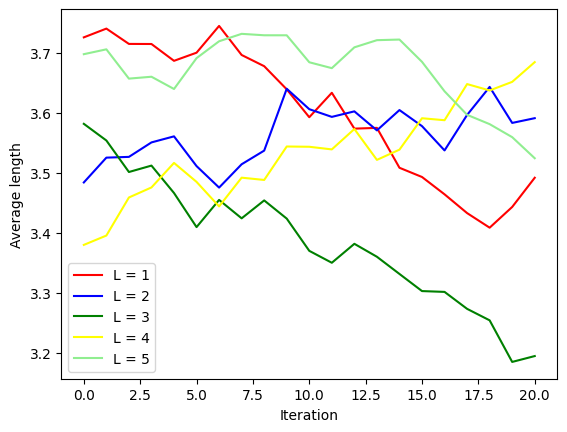

In [ ]:
def _moving_avg(x, N=100):
    return np.convolve(np.array(x), np.ones((N,))/N, mode='valid')

# Iterate over each sublist in path_lengths
for i, path_length in enumerate(path_lengths_final):
    # Plot the moving average of each sublist
    plt.plot(_moving_avg(path_length, 30), label=f'L = {i+1}', color=['red', 'blue', 'green','yellow','lightgreen'][i])

plt.ylabel('Average length')
plt.xlabel('Iteration')
plt.legend()
plt.show()

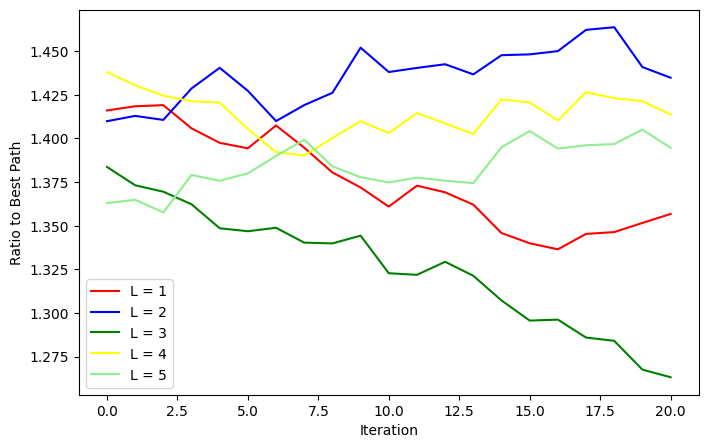

In [ ]:
ratios_final = []
for path_lengths, best_lengths in zip(path_lengths_final, best_lengths_final):
    ratios = [partial_tour_dist / best_dist for partial_tour_dist, best_dist in zip(path_lengths, best_lengths)]
    ratios_final.append(ratios)

plt.figure(figsize=(8, 5))

# Iterate over each sublist in ratios_final
for i, ratios in enumerate(ratios_final):
    # Plot the moving average of each sublist
    plt.plot(_moving_avg(ratios, 30), label=f'L = {i+1}', color=['red', 'blue', 'green','yellow','lightgreen'][i])

plt.ylabel('Ratio to Best Path')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
from itertools import combinations
import copy

def plot_graph(G, pos, edge_labels, edges_to_highlight=None, title="", color='r'):
    """
    Plot a graph using NetworkX, optionally highlighting specific edges.

    Parameters:
    - G: NetworkX graph object.
    - pos: Dictionary of node positions generated by NetworkX layout algorithm.
    - edge_labels: Dictionary of edge labels.
    - edges_to_highlight: List of edges to highlight (optional).
    - title: Title for the plot (optional).
    - color: Edge color for highlighted edges (default is 'r' for red).

    Returns:
    None
    """
    plt.figure()
    nx.draw(G, pos=pos, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    if edges_to_highlight:
        for edge in edges_to_highlight:
            nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], edge_color=color, width=2.0)

    plt.title(title)
    plt.show()

# Get file with smallest distance
all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith('.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))

# Load checkpoint
fully_connected_qubits = list(combinations(list(range(N_NODES)), 2))
Q_func, Q_net, optimizer, lr_scheduler = init_model(fully_connected_qubits, os.path.join(FOLDER_NAME, shortest_fname))

# Generate example solutions
NR_NODES = 7
for sample in range(10):
    coords, weight_mat = get_graph_mat(n=NR_NODES)
    W = torch.tensor(weight_mat, dtype=torch.float32, requires_grad=False, device=device)

    partial_tour = []
    initial_node = 0
    available_nodes = list(range(1, N_NODES))
    nodes = range(0, N_NODES)

    # current state (tuple and tensor)
    edge_weights = []
    for q in fully_connected_qubits:
        edge_weights.append(weight_mat[q[0], q[1]])
    current_state = graph_to_list(
        nodes=nodes,
        edge_weights=edge_weights,
        available_nodes=available_nodes
    )
    current_state = State(weight_mat=weight_mat,state_list=current_state, is_final=len(available_nodes) == 0, partial_tour=partial_tour, available_nodes=copy.copy(available_nodes))
    current_state_tsr = torch.tensor(current_state.state_list, dtype=torch.float32, requires_grad=False, device=device).unsqueeze(0)

    while len(available_nodes) > 0:
        observables = get_observables(
                partial_tour=partial_tour,
                available_nodes=available_nodes,
                weight_mat=weight_mat,
                nodes=nodes
            )
        next_node, est_reward = Q_func.get_best_action(current_state_tsr, observables)

        available_nodes.remove(next_node)

        if partial_tour:
            last_element = partial_tour[-1][-1]
        else:
            last_element = 0
        partial_tour = partial_tour + [(last_element, next_node)]

        current_state = graph_to_list(
            nodes=nodes,
            edge_weights=edge_weights,
            available_nodes=available_nodes
        )
        current_state = State(weight_mat=weight_mat,state_list=current_state, is_final=len(available_nodes) == 0, partial_tour=partial_tour, available_nodes=copy.copy(available_nodes))
        current_state_tsr = torch.tensor(current_state.state_list, dtype=torch.float32, requires_grad=False, device=device).unsqueeze(0)

    print("============================================")
    G = generate_networkx_graph(coords, weight_mat)
    tsp_solution = nx.approximation.traveling_salesman_problem(G, cycle=True)

    pos = nx.get_node_attributes(G, 'pos')
    edge_labels = {(i, j): f'{weight:.2f}' for (i, j, weight) in G.edges(data='weight')}

    # Plot tsp_edge_labels on a separate plot with green edges
    total_distance = sum(G[u][v]['weight'] for u, v in zip(tsp_solution, tsp_solution[1:]))
    print("Best graph length: ")
    print(total_distance)
    tsp_edge_labels = [(u, v) for u, v in zip(tsp_solution, tsp_solution[1:])]
    plot_graph(G, pos, edge_labels, edges_to_highlight=tsp_edge_labels, title="Best Tour Approximation", color='g')

    # Plot converted_partial_tour on a separate plot with red edges
    converted_partial_tour = [(int(start), int(end)) for start, end in partial_tour]
    converted_partial_tour.append((converted_partial_tour[-1][1], converted_partial_tour[0][0]))
    partial_tour_distance = sum(G[edge[0]][edge[1]]['weight'] for edge in converted_partial_tour)
    print("Distance of the computed partial tour:")
    print(partial_tour_distance)
    plot_graph(G, pos, edge_labels, edges_to_highlight=converted_partial_tour, title="Computed Partial Tour")

    plt.show()

In [ ]:
print(losses)
# Plotting the list
plt.plot(losses, marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of List Values')
plt.grid(True)
plt.show()